In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import scipy.signal
from inputs import one_dimensional_peak, two_dimensional_peak, three_dimensional_peak
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [183]:
class AbsSigmoid(object):
    def __init__(self, beta=100, threshold=0):
        self.beta = beta
        self.threshold = threshold
    def __call__(self, x):
        return 0.5 * (1 + self.beta * (x-self.threshold)) / (1 + self.beta * np.abs(x-self.threshold)) + 0.5
    
class ExpSigmoid(object):
    def __init__(self, beta=100):
        self.beta = beta
    def __call__(self, x):
        return 1 / (1 + np.exp(- self.beta * x))

class GaussKernel(object):
    def __init__(self, c, sigma, normalize=True, dims=2):
        self.c = c
        self.sigma = sigma
        self.normalize = normalize
        self.kernel_width = int(np.ceil(sigma*5)) # limit is always 5 
        # kernel width should always be an odd number --> like that in cedar
        if self.kernel_width % 2 == 0:
            self.kernel_width += 1
        self.dims = dims
        
        x = np.arange(self.kernel_width)
        cx = self.kernel_width//2
        
        if self.dims == 1 or self.dims == 0:
            dx = np.abs(x - cx)
            
        elif self.dims == 2:
            grid_x, grid_y = np.meshgrid(x, x)
            dx = np.sqrt((grid_x - cx)**2 + (grid_y - cx)**2)
         
        elif self.dims == 3:
            grid_x, grid_y, grid_z = np.meshgrid(x, x, x)
            dx = np.sqrt((grid_x - cx)**2 + (grid_y - cx)**2 + (grid_z - cx)**2)
            
        kernel_matrix = np.exp(-dx**2 / (2*self.sigma**2))
        if self.normalize:
            kernel_matrix /= np.sum(kernel_matrix)
        self.kernel_matrix = self.c * kernel_matrix
        
        # if the kernel is 0-dimensional it only consists of the central scalar value
        # need to compute from 1-dimensional kernel for normalizaton to work correctly
        if self.dims == 0:
            self.kernel_matrix = self.kernel_matrix[cx]
            
    def __call__(self):
        return self.kernel_matrix
    
    
class BoxKernel(object):
    ''' Implementation of the BoxKernel of cedar.
        Since the BoxKernel is only used with 0-dimensional fields in the 
        architecture this is a simplified implementation of the BoxKernel
        without the width parameter which is only needed for 1- or higher 
        dimensional fields.
    '''
    def __init__(self, amplitude):
        # dimensionality of BoxKernel always 0
        self.dims = 0 
        self.amplitude = amplitude
        self.kernel_matrix = amplitude
        
    def __call__(self):
        return self.kernel_matrix
    
    
def pad_and_convolve(inp, kernel, border):
    
    # test if input consists of more than one number, i.e. field not 0-dimensional
    if inp.shape != ():
        # compute padding values
        kernel_width = kernel.shape[0]
        pad_width_f = kernel_width//2
        pad_width_b = kernel_width//2 if kernel_width % 2 == 1 else kernel_width//2 - 1 

        # translate border type to boundary mode
        mode = 'wrap' if border == 'cyclic' else 'constant'
        # pad the input
        inp_padded = np.pad(inp, pad_width=(pad_width_f, pad_width_b), mode=mode)
    
    # otherwise the kernel is just a scalar and can directly be convolved with the 
    # scalar input
    else:
        inp_padded = inp
    # perform the convolution
    conv = scipy.signal.convolve(inp_padded, kernel, mode='valid')
    
    return conv
    
    
class NeuralField(object):
    ''' Neural Field object similar to the Neural Field used by cedar.
        Implements the Neural Field equation of Dynamic Field theory.
        The dimensionality of the Neural Field is read from the number
        of elements in the sizes parameter. 
    '''
    def __init__(self, sizes, h, tau, kernel, 
                 c_glob=1, 
                 nonlinearity=AbsSigmoid(beta=100),
                 border_type='zero-filled borders',
                 input_noise_gain=0.1):
        self.u = np.ones(sizes) * h
        self.h = h
        self.tau = tau
        self.sizes = sizes
        self.c_glob = c_glob
        self.nonlinearity = nonlinearity
        self.border_type = border_type
        self.input_noise_gain = input_noise_gain
        self.probes = {"sigmoided activation": [],
                       "lateral interaction": [],
                       "activation": [],
                       "sigmoided sum": []}
        
        assert (kernel.dims == len(sizes)), "Kernel must have same number of " + \
                                             "dimensions as Neural Field!"
        self.kernel = kernel
        
        self.kernel_matrix = kernel()
        
    def update(self, stim):
        a = self.nonlinearity(self.u)
        self.probes["sigmoided activation"].append(a)
        recurr = pad_and_convolve(a, self.kernel_matrix, self.border_type)
        self.probes["lateral interaction"].append(recurr)
        # in cedar the noise is divided by sqrt(tau)
        self.u += (-self.u + self.h + self.c_glob * np.sum(a) + recurr + stim)/self.tau + \
                  (self.input_noise_gain * np.random.randn(*self.sizes)) / self.tau 
        self.probes["activation"].append(np.array(self.u))
        self.probes["sigmoided sum"].append(np.sum(a))
        return self.u
        
    def make_node(self):
        return nengo.Node(lambda t, x: self.update(x.reshape(self.sizes)).flatten(),
                          size_in=int(np.product(self.sizes)), 
                          size_out=int(np.product(self.sizes)))
    

In [184]:
dim = 3

c_glob = 0
tau = 50
h = -5
noise = 0.1
border_type = "cyclic"

if dim == 0:
    kernel_ampl = 2
    kernel = BoxKernel(amplitude=kernel_ampl)
#     kernel = GaussKernel(c=2, sigma=3, dims=0, normalize=False)
    sizes = [] 
    tau = tau*1.25
    
elif dim == 1:
    sizes = [50]
    kernel_ampl = 1
    kernel_std = 3
    kernel_dims = 1
    normalize = True
    kernel = GaussKernel(c=kernel_ampl, sigma=kernel_std, dims=kernel_dims, normalize=normalize)
    
elif dim == 2:
    sizes = [50,50]
    kernel_ampl = 2
    kernel_std = 5
    kernel_dims = 2
    normalize = True
    kernel = GaussKernel(c=kernel_ampl, sigma=kernel_std, dims=kernel_dims, normalize=normalize)
    
elif dim == 3:
    sizes = [50,50,50]
    kernel_ampl = 1
    kernel_std = 5
    kernel_dims = 3
    normalize = True
    kernel = GaussKernel(c=kernel_ampl, sigma=kernel_std, dims=kernel_dims, normalize=normalize)
    
field = NeuralField(sizes=sizes, h=h, tau=tau, c_glob=c_glob, kernel=kernel, border_type=border_type, 
                    input_noise_gain=noise, nonlinearity=AbsSigmoid(beta=100))            

In [185]:
model = nengo.Network()
with model:
    
    if dim == 0:
        s = nengo.Node(4.9)
    elif dim == 1:
        s = nengo.Node(list(one_dimensional_peak(5,std=5,a=6.5,size=50).flatten()))
    elif dim == 2:
        s = nengo.Node(list(two_dimensional_peak(5,5,std=5,a=6.5,size=50).flatten()))
    elif dim == 3:
        s = nengo.Node(list(three_dimensional_peak(5,5,5,std=8,a=6.5,size=50).flatten()))
    
    u = field.make_node()
    
    nengo.Connection(s, u)
                                                      
    activation_probe = nengo.Probe(u)
    external_input_probe = nengo.Probe(s)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(0.4)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [186]:
# print sum(sigmoided activation) after convergence
# for c_glob=0 it is 1113 for cedar
print(field.probes['sigmoided sum'][-1])

1277.0900532955095


# Plot activation, sigmoided activation and lateral interaction

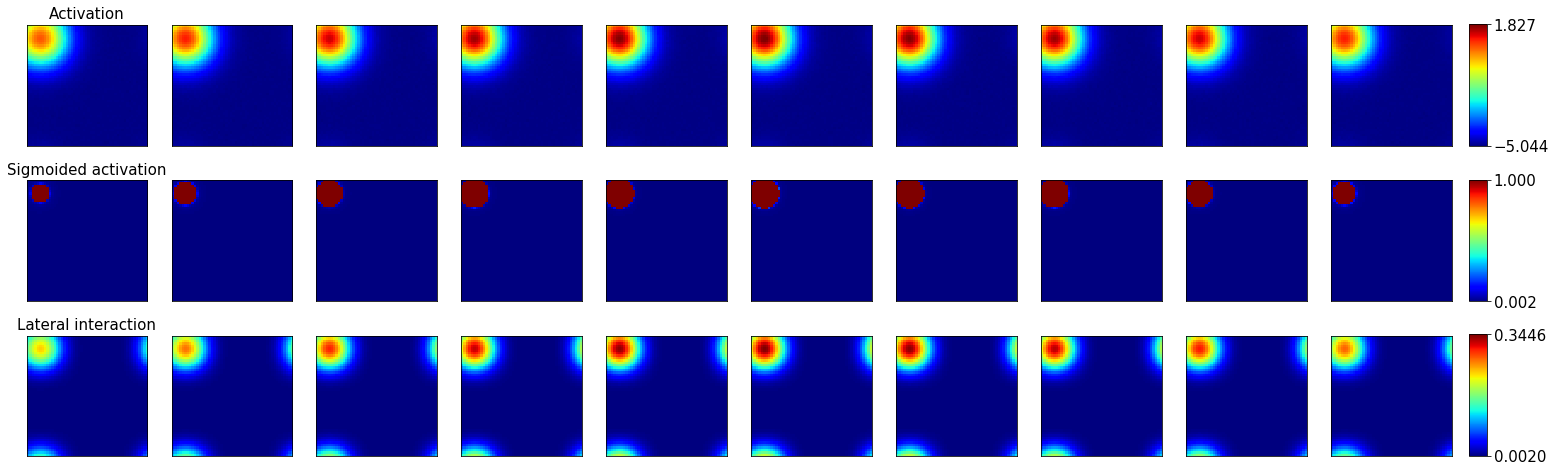

In [187]:
# different kind of plots for different dimensionalities

if dim == 0:
    plt.figure(figsize=(12,8))
    plt.plot(sim.data[activation_probe], label='activation')
    plt.plot(field.probes["sigmoided activation"], label='sigmoided activation')
    plt.plot(field.probes["lateral interaction"], label='lateral interaction')
    plt.legend()
    
elif dim == 1:
    num_images = 10
    fig, axs = plt.subplots(3, num_images, sharex="col", sharey="row", figsize=(24,6), gridspec_kw={"hspace": 0.25})

    axs[0,0].set_title('Activation', fontsize=15)
    axs[0,0].set_ylim([np.min(field.probes["activation"])-0.1,np.max(field.probes["activation"])+0.1])
    axs[1,0].set_title('Sigmoided activation', fontsize=15)
    axs[1,0].set_ylim([np.min(field.probes["sigmoided activation"])-0.1,
                       np.max(field.probes["sigmoided activation"])+0.1])
    axs[2,0].set_title('Lateral interaction', fontsize=15)
    axs[2,0].set_ylim([np.min(field.probes["lateral interaction"])-0.1,
                       np.max(field.probes["lateral interaction"])+0.1])
    
    for i in range(num_images):
#         ind = int(field.probes["activation"].shape[0]/num_images)
        ind = i*100
        
        axs[0,i].plot(field.probes["activation"][ind])
        axs[1,i].plot(field.probes["sigmoided activation"][ind])
        axs[2,i].plot(field.probes["lateral interaction"][ind])
        
elif dim == 2:
    num_images = 10
    fig, axs = plt.subplots(3, num_images, figsize=(24,6), gridspec_kw={"hspace": 0.1, "wspace": 0.5})
    
    axs[0,0].set_title('Activation', fontsize=15)
    axs[1,0].set_title('Sigmoided activation', fontsize=15)
    axs[2,0].set_title('Lateral interaction', fontsize=15)
    
    plt.setp(axs, xticks=[], yticks=[])
    
    for i in range(num_images):
        ind = i*40
        
        im_ac = axs[0,i].imshow(sim.data[activation_probe][ind].reshape(sizes), cmap='jet')
        im_sa = axs[1,i].imshow(field.probes["sigmoided activation"][ind], cmap='jet')
        im_li = axs[2,i].imshow(field.probes["lateral interaction"][ind], cmap='jet')
    
        act_min, act_max = np.min(sim.data[activation_probe][ind]), np.max(sim.data[activation_probe][ind])
        sa_min, sa_max = np.min(field.probes["sigmoided activation"][ind]), np.max(field.probes["sigmoided activation"][ind])
        li_min, li_max = np.min(field.probes["lateral interaction"][ind]), np.max(field.probes["lateral interaction"][ind])
        
        divider = make_axes_locatable(axs[0,i])
        cax_ac = divider.append_axes('right', size="10%", pad=0.05)
        fig.colorbar(im_ac, cax_ac, ticks=[act_min, act_max])

        divider = make_axes_locatable(axs[1,i])
        cax_sa = divider.append_axes('right', size="10%", pad=0.05)
        fig.colorbar(im_sa, cax_sa, ticks=[sa_min, sa_max])

        divider = make_axes_locatable(axs[2,i])
        cax_li = divider.append_axes('right', size="10%", pad=0.05)
        fig.colorbar(im_li, cax_li, ticks=[li_min, li_max])
    
elif dim == 3:
    # only plot at one point in time 
    time_ind = 399
    num_images = 10
    
    fig, axs = plt.subplots(3, num_images, figsize=(24,8), gridspec_kw={"hspace": 0.25})
    
    axs[0,0].set_title('Activation', fontsize=15)
    axs[1,0].set_title('Sigmoided activation', fontsize=15)
    axs[2,0].set_title('Lateral interaction', fontsize=15)
    act_min, act_max = np.min(sim.data[activation_probe][time_ind]), np.max(sim.data[activation_probe][time_ind])
    sa_min, sa_max = np.min(field.probes["sigmoided activation"][time_ind]), np.max(field.probes["sigmoided activation"][time_ind])
    li_min, li_max = np.min(field.probes["lateral interaction"][time_ind]), np.max(field.probes["lateral interaction"][time_ind])
    plt.setp(axs, xticks=[], yticks=[])
    
    for i in range(num_images):
        # just get the first 10 images, since the gaussian peak is at the beginning
        ind = i
        s0, s1, s2 = sizes[0], sizes[1], sizes[2]
        im_ac = axs[0,i].imshow(sim.data[activation_probe][time_ind][ind*s1*s2:ind*s1*s2+s1*s2].reshape(s1,s2), 
                                cmap='jet', vmin=act_min, vmax=act_max)
        im_sa = axs[1,i].imshow(field.probes["sigmoided activation"][time_ind][ind], cmap='jet', 
                                vmin=sa_min, vmax=sa_max)
        im_li = axs[2,i].imshow(field.probes["lateral interaction"][time_ind][ind], cmap='jet', 
                                vmin=li_min, vmax=li_max)
    
    fig.subplots_adjust(right=0.95)
    cax_ac = fig.add_axes([0.96, 0.667, 0.01, 0.211])
    cbar_ac = fig.colorbar(im_ac, cax_ac, ticks=[act_min, act_max])
    cbar_ac.ax.tick_params(labelsize=15)
    
    cax_sa = fig.add_axes([0.96, 0.397, 0.01, 0.211])
    cbar_sa = fig.colorbar(im_sa, cax_sa, ticks=[sa_min, sa_max])
    cbar_sa.ax.tick_params(labelsize=15)
    
    cax_li = fig.add_axes([0.96, 0.129, 0.01, 0.211])
    cbar_li = fig.colorbar(im_li, cax_li, ticks=[li_min, li_max])
    cbar_li.ax.tick_params(labelsize=15)
    
plt.show()

In [188]:
max_act = np.max(sim.data[activation_probe], axis=1)
# print maximum activation after convergence
print(max_act[-10:])


[1.81541833 1.81466162 1.8180187  1.82033563 1.82382786 1.82428793
 1.82390348 1.8228292  1.82562453 1.82658935]
